#Example 1: Average ChIP-seq signal over promoters

This example demonstrates the use of `metaseq` for performing a common
task when analyzing ChIP-seq data: what does transcription factor binding signal look like near transcription start sites?

The IPython Notebook of this example can be found in the source directory (`doc/source/example_session.ipynb`) or at http://nbviewer.ipython.org/github/daler/metaseq/blob/master/doc/source/example_session.ipynb

The syntax of this document follows that of the IPython notebook. For example, calls out to the shell are prefixed with a "`!`"; if not then the code is run in Python.

In [1]:
# Enable in-line plots for this example
%matplotlib inline

##Example data
This example uses data that can be downloaded from https://github.com/daler/metaseq-example-data. See that repository for details on how the data were prepared; here's how to download the prepared data:

In [2]:
%%bash
example_dir="metaseq-example"
if [ -e $example_dir ]; then echo "already exists";
else
    mkdir -p $example_dir
    (cd $example_dir \
    && wget --progress=dot:giga https://raw.githubusercontent.com/daler/metaseq-example-data/master/metaseq-example-data.tar.gz \
    && tar -xzf metaseq-example-data.tar.gz \
    && rm metaseq-example-data.tar.gz)
fi

--2015-11-15 19:50:38--  https://raw.githubusercontent.com/daler/metaseq-example-data/master/metaseq-example-data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.27.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.27.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96655384 (92M) [application/octet-stream]
Saving to: ‘metaseq-example-data.tar.gz’

     0K ........ ........ ........ ........ 34% 81.3M 1s
 32768K ........ ........ ........ ........ 69% 68.6M 0s
 65536K ........ ........ ........ ....    100% 99.1M=1.1s

2015-11-15 19:50:40 (80.5 MB/s) - ‘metaseq-example-data.tar.gz’ saved [96655384/96655384]



In [3]:
# From now on, we can just use `data_dir`
data_dir = 'metaseq-example/data'

In [4]:
# What did we get?
!ls $data_dir

GSM847565_SL2585.gtf.gz
GSM847565_SL2585.table
GSM847566_SL2592.gtf.gz
GSM847566_SL2592.table
Homo_sapiens.GRCh37.66_chr17.gtf
Homo_sapiens.GRCh37.66_chr17.gtf.db
Homo_sapiens.GRCh37.66.gtf.gz
wgEncodeHaibTfbsK562Atf3V0416101AlnRep1_chr17.bam
wgEncodeHaibTfbsK562Atf3V0416101AlnRep1_chr17.bam.bai
wgEncodeHaibTfbsK562Atf3V0416101RawRep1_chr17.bigWig
wgEncodeHaibTfbsK562RxlchV0416101AlnRep1_chr17.bam
wgEncodeHaibTfbsK562RxlchV0416101AlnRep1_chr17.bam.bai
wgEncodeHaibTfbsK562RxlchV0416101RawRep1_chr17.bigWig


* The `.bam` and `.bam.bai` files are from an ENCODE project ChIP-Seq experiment in the human erythroid K562 cell line for the ATF3 transcription factor and its associated input control. See the [ENCODE page](https://www.encodeproject.org/experiments/ENCSR000DOG/) for details.

* The `.bigWig` files are from the same experiment, downloaded from ENCODE

* The GTF annotation files are downloaded from Ensembl (release 66) for hg19.

* The `Homo_sapiens.GRCh37.66_chr17.gtf.db` file is a `gffutils` database that was prepared from the GTF file.

* The `GSM*.gtf.gz` data are Cufflinks output from GEO accession GSM847565 and GSM847566. These were then parsed and reformatted into the corresponding `GSM*.table` files.

## Getting TSSes
Our goal is to look at the ChIP-seq signal over transcription start sites (TSSes) of genes.  Typically in this sort of analysis we start with annotations; here we're using the annotations from Ensembl.  If we're lucky, TSSes will already be annotated.  Failing that, perhaps 5'UTRs are annotated, so we could take the 5' end of the 5'UTR as the TSS. Let's see what the Ensembl data gives us.

In [5]:
!head -n 3 $data_dir/Homo_sapiens.GRCh37.66_chr17.gtf

chr17	protein_coding	exon	30898	31270	.	-	.	 gene_id "ENSG00000187939"; transcript_id "ENST00000343572"; exon_number "1"; gene_name "DOC2B"; gene_biotype "protein_coding"; transcript_name "DOC2B-201";
chr17	protein_coding	CDS	30898	31270	.	-	0	 gene_id "ENSG00000187939"; transcript_id "ENST00000343572"; exon_number "1"; gene_name "DOC2B"; gene_biotype "protein_coding"; transcript_name "DOC2B-201"; protein_id "ENSP00000343665";
chr17	protein_coding	start_codon	31268	31270	.	-	0	 gene_id "ENSG00000187939"; transcript_id "ENST00000343572"; exon_number "1"; gene_name "DOC2B"; gene_biotype "protein_coding"; transcript_name "DOC2B-201";


GTF files have the feature type in the 3rd field.  So what kind of featuretypes do we have here?

In [6]:
!cut -f 3  $data_dir/Homo_sapiens.GRCh37.66_chr17.gtf | sort | uniq -c

  34137 CDS
  45801 exon
   3355 start_codon
   3265 stop_codon


With only these featuretypes to work with, we would need to do the following to identify the TSS of each transcript:
   * find all exons for the transcript
   * sort the exons by start position
   * if the transcript is on the "+" strand, TSS is the start position of the first exon
   * if the transcript is on the "-" strand, TSS is the end position of the last exon

Luckily, [`gffutils`](https://github.com/daler/gffutils) is able to infer transcripts and genes from a GTF file.  The inferred transcripts and genes are already in the prepared `gffutils` database, at `$data_dir/Homo_sapiens.GRCh37.66_chr17.gtf.db`. First we connect to it:

In [7]:
import os
import gffutils
db = gffutils.FeatureDB(os.path.join(data_dir, 'Homo_sapiens.GRCh37.66_chr17.gtf.db'))

We'll use [`pybedtools`](https://github.com/daler/pybedtools) for interval manipulation.

Here we create a generator function that iterates through all annotated transcripts in the database. For each transcript, we convert it to a `pybedtools.Interval` and use the `TSS` function to give us the 1-bp position of the TSS, and save it as a new file.

Here is a general usage pattern for `gffutils` and `pybedtools`: do the work in a generator function, and pass the generator to `pybedtools.BedTool`.  This uses very little memory, and scales well to hundreds of thousands of features.

In [8]:
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval


def tss_generator():
    """
    Generator function to yield TSS of each annotated transcript
    """
    for transcript in db.features_of_type('transcript'):
        yield TSS(asinterval(transcript), upstream=1, downstream=0)

        
# A BedTool made out of a generator, and saved to file.
tsses = pybedtools.BedTool(tss_generator()).saveas('tsses.gtf')

Now that we have a TSS file, we can modify it in different ways. Maybe we want to look at TSS +/- 1kb. Or 5kb. Or just 3kb upstream.

For this example, let's use `pybedtools` to add 1kb to either side of the TSS. This uses the BEDTools `slop` routine; see the docs for that program for how to make changes to up/downstream distances.

In [9]:
tsses_1kb = tsses.slop(b=1000, genome='hg19', output='tsses-1kb.gtf')

##Creating the arrays
`metaseq` works with the concepts of signal and windows. In this example, the signal is ChIP data, and the windows are TSS +/- 1kb.

The first step is to create “genomic signal” objects out of the data. Since our example files are BAM files, we specify the kind=’bam’, but if you have your own data in a different format (bigWig, bigBed, BED, GFF, GTF, VCF) then specify that format instead (see :func:`metaseq.genomic_signal()`).

We need to pass the filenames of the BAM files:

In [10]:
import metaseq

ip_signal = metaseq.genomic_signal(
    os.path.join(data_dir, 'wgEncodeHaibTfbsK562Atf3V0416101AlnRep1_chr17.bam'),
    'bam')

input_signal = metaseq.genomic_signal(
    os.path.join(data_dir, 'wgEncodeHaibTfbsK562RxlchV0416101AlnRep1_chr17.bam'),
    'bam')

Now we can create the arrays of signal over each window. Since this can be a time-consuming step, the first time this code is run it will cache the arrays on disk. The next time this code is run, it will be quickly loaded. Trigger a re-run by deleting the `.npz` file.

Here, with the `BamSignal.array` method, we bin each promoter region into 100 bins, and calculate the signal in parallel across as many CPUs as are available. We do this for the IP signal and input signals separately. Then, since these are BAM files of mapped reads, we scale the arrays to the library size. The scaled arrays are then saved to disk, along with the windows that were used to create them.

In [11]:
import multiprocessing
processes = multiprocessing.cpu_count()


# The signal is the IP ChIP-seq BAM file.
ip_array = ip_signal.array(

    # Look at signal over these windows
    tsses_1kb,

    # Bin signal into this many bins per window
    bins=100,

    # Use multiple CPUs. Dramatically speeds up run time.
    processes=processes)

# Do the same thing for input.
input_array = input_signal.array(
    tsses_1kb,
    bins=100,
    processes=processes)

# Normalize to library size. The values in the array
# will be in units of "reads per million mapped reads"
ip_array /= ip_signal.mapped_read_count() / 1e6
input_array /= input_signal.mapped_read_count() / 1e6

# Cache to disk. The data will be saved as "example.npz" and "example.features".
metaseq.persistence.save_features_and_arrays(
    features=tsses,
    arrays={'ip': ip_array, 'input': input_array},
    prefix='example',
    link_features=True,
    overwrite=True)


## Loading the arrays

Now that we’ve saved to disk, at any time in the future we can load the data without having to regenerate them:

In [12]:
features, arrays = metaseq.persistence.load_features_and_arrays(prefix='example')

Let’s do some double-checks.

In [13]:
# How many features?
assert len(features) == 5708

# This ought to be exactly the same as the number of features in `tsses_1kb.gtf`
assert len(features) == len(tsses_1kb) == 5708

# This shows that `arrays` acts like a dictionary
assert sorted(arrays.keys()) == ['input', 'ip']

# This shows that the IP and input arrays have one row per feature, and one column per bin
assert arrays['ip'].shape == (5708, 100) == arrays['input'].shape

## Line plot of average signal
Now that we have NumPy arrays of signal over windows, there’s a lot we can do. One easy thing is to simply plot the mean signal of IP and of input. Let’s construct meaningful values for the x-axis, from -1000 to +1000 over 100 bins. We'll do this with a NumPy array.

In [14]:
import numpy as np
x = np.linspace(-1000, 1000, 100)

Then plot, using standard [`matplotlib`](http://matplotlib.org/) commands:

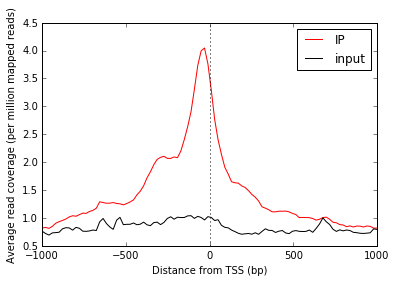

In [15]:
# Import plotting tools
from matplotlib import pyplot as plt


# Create a figure and axes
fig = plt.figure()
ax = fig.add_subplot(111)


# Plot the IP:
ax.plot(
    # use the x-axis values we created
    x,
    
    # axis=0 takes the column-wise mean, so with 
    # 100 columns we'll have 100 means to plot
    arrays['ip'].mean(axis=0),
    
    # Make it red
    color='r',

    # Label to show up in legend
    label='IP')


# Do the same thing with the input
ax.plot(
    x,
    arrays['input'].mean(axis=0),
    color='k',
    label='input')


# Add a vertical line at the TSS, at position 0
ax.axvline(0, linestyle=':', color='k')


# Add labels and legend
ax.set_xlabel('Distance from TSS (bp)')
ax.set_ylabel('Average read coverage (per million mapped reads)')
ax.legend(loc='best');

## Adding a heatmap

Let's work on improving this plot, one step at a time. 

We don't really know if this average signal is due to a handful of really strong peaks, or if it's moderate signal over many peaks.  So one improvement would be to include a heatmap of the signal over all the TSSs.

First, let's create a single normalized array by subtracting input from IP:

In [16]:
normalized_subtracted = arrays['ip'] - arrays['input']

 `metaseq` comes with some helper functions to simplify this kind of plotting.  The `metaseq.plotutils.imshow` function is one of these; here the arguments are described:

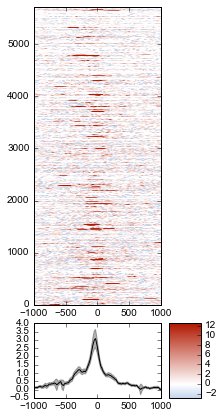

In [17]:
# Tweak some font settings so the results look nicer
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# the metaseq.plotutils.imshow function does a lot of work,
# we just have to give it the right arguments:
fig = metaseq.plotutils.imshow(
    
    # The array to plot; here, we've subtracted input from IP.
    normalized_subtracted,
    
    # X-axis to use
    x=x,
    
    # Change the default figure size to something smaller for this example
    figsize=(3, 7),
    
    # Make the colorbar limits go from 5th to 99th percentile. 
    # `percentile=True` means treat vmin/vmax as percentiles rather than
    # actual values.
    percentile=True,
    vmin=5,
    vmax=99,
    
    # Style for the average line plot (black line)
    line_kwargs=dict(color='k', label='All'),
    
    # Style for the +/- 95% CI band surrounding the 
    # average line (transparent black)
    fill_kwargs=dict(color='k', alpha=0.3),
)

In [18]:
print "asdf"


asdf


## Sorting the array
The array is not very meaningful as currently sorted.  We can adjust the sorting this either by re-ordering the array before plotting, or using the `sort_by` kwarg when calling `metaseq.plotutils.imshow`. Let's sort the rows by their mean value:

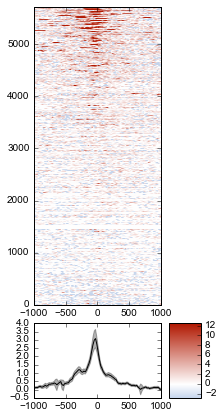

In [19]:
fig = metaseq.plotutils.imshow(
    
    # These are the same arguments as above.
    normalized_subtracted,
    x=x,
    figsize=(3, 7),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    
    # This is new: sort by mean signal
    sort_by=normalized_subtracted.mean(axis=1)
)

We can use any number of arbitrary sorting methods. For example, this sorts the rows by the position of the highest signal in the row.  Note that the line plot, which is the column-wise average, remains unchanged since we're still using the same data. The rows are just sorted differently.

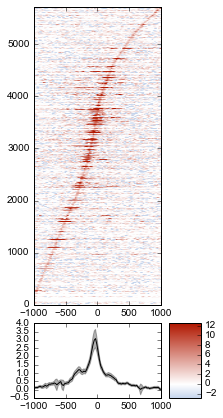

In [20]:
fig = metaseq.plotutils.imshow(
    
    # These are the same arguments as above.
    normalized_subtracted,
    x=x,
    figsize=(3, 7),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    
    # This is new: sort by mean signal
    sort_by=np.argmax(normalized_subtracted, axis=1)
)

## Customizing the axes styles
Let's go back to the sorted-by-mean version.

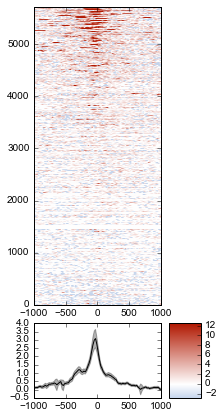

In [21]:
fig = metaseq.plotutils.imshow(
    normalized_subtracted,
    x=x,
    figsize=(3, 7),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=normalized_subtracted.mean(axis=1)
)

Now we'll make some tweaks to the plot.  The figure returned by `metaseq.plotutils.imshow` has attributes `array_axes`, `line_axes`, and `cax`, which can be used as an easy way to get handles to the axes for further configuration.  Let's make some additional tweaks:

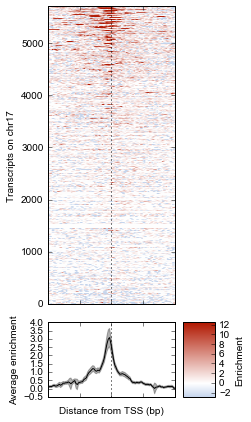

In [22]:
# "line_axes" is our handle for working on the lower axes.
# Add some nicer labels.
fig.line_axes.set_ylabel('Average enrichment');
fig.line_axes.set_xlabel('Distance from TSS (bp)');

# "array_axes" is our handle for working on the upper array axes.
# Add a nicer axis label
fig.array_axes.set_ylabel('Transcripts on chr17')

# Remove the x tick labels, since they're redundant
# with the line axes
fig.array_axes.set_xticklabels([])

# Add a vertical line to indicate zero in both the array axes
# and the line axes
fig.array_axes.axvline(0, linestyle=':', color='k')
fig.line_axes.axvline(0, linestyle=':', color='k')

fig.cax.set_ylabel("Enrichment")
fig


# Integrating with RNA-seq expression data

Often we want to compare ChIP-seq data with RNA-seq data. But RNA-seq data typically is presented as gene ID, while ChIP-seq data is presented as genomic coords. These can be tricky to reconcile.

We will use example data from ATF3 knockdown experiments them to subset the ChIP signal by those TSSs that were affected by knockdown and those that were not.

This example uses pre-processed data downloaded from GEO.  We'll use a simple (and naive) 2-fold cutoff to identify transcripts that went up, down, or were unchanged upon ATF3 knockdown. In real-world analysis, you'd probaby have a table from DESeq2 or edgeR analysis that you would use instead.

## RNA-seq data wrangling: loading data
The `metaseq.results_table` module has tools for working with this kind of data (for example, the `metaseq.results_table.DESeq2Results` class).  Here, we will make a generic `ResultsTable` which handles any kind of tab-delimited data. It's important to specify the index column. This is the column that contains the transcript IDs in these files.

In [23]:
from metaseq.results_table import ResultsTable

control = ResultsTable(
    os.path.join(data_dir, 'GSM847565_SL2585.table'),
    import_kwargs=dict(index_col=0))

knockdown = ResultsTable(
    os.path.join(data_dir, 'GSM847566_SL2592.table'),
    import_kwargs=dict(index_col=0))


`metaseq.results_table.ResultsTable` objects are wrappers around `pandas.DataFrame` objects, so if you already know `pandas` you know how to manipulate these objects.  The `pandas.DataFrame` is always available as the `data` attribute.

Here are the first 5 rows of the `control` object, which show that the index is `id`, which are Ensembl transcript IDs, and there are two columns, `score` and `fpkm`:

In [24]:
# ---------------------------------------------------------
# Inspect results to see what we're working with

print len(control.data)
control.data.head()

85699


,score,fpkm
id,,
ENST00000456328,108.293111,1.118336
ENST00000515242,87.233019,0.830617
ENST00000518655,175.175609,2.367682
ENST00000473358,343.232679,9.795265
ENST00000408384,0.000000,0.000000


## RNA-seq data wrangling: aligning RNA-seq data with ChIP-seq data
We should ensure that `control` and `knockdown` have their transcript IDs in the same order as the rows in the heatmap array, and that they only contain transcript IDs from chr17.

The `ResultsTable.reindex_to` method is very useful for this -- it takes a `pybedtools.BedTool` object and re-indexes the underlying dataframe so that the order of the dataframe matches the order of the features in the file. In this way we can re-align RNA-seq data to ChIP-seq data for more direct comparison.

Remember the `tsses_1kb` object that we used to create the array?  That defined the order of the rows in the array. We can use that to re-index the dataframes.  Let's look at the first line from that file to see how the transcript ID information is stored:

In [25]:
# ---------------------------------------------------------
# Inspect the GTF file originally used to create the array

print tsses_1kb[0]


chr17	gffutils_derived	transcript	37025255	37027255	.	+	.	transcript_id "ENST00000318008"; gene_id "ENSG00000002834";



The Ensembl transcript ID is stored in the `transcript_id` field of the GTF attributes:

    transcript_id "ENST00000318008"; gene_id "ENSG00000002834";

The `ResultsTable` is indexed by transcript ID.  Note that DESeq2 and edgeR results are typically indexed by gene, rather than trancscript, ID. So when working with your own data, be sure to select the GTF attribute whose values will be found in the `ResultsTable` index.

Here, we tell the `ResultsTable.reindex_to` method which attribute it should pay attention to when realigning the data:

In [26]:
# ---------------------------------------------------------
# Re-align the ResultsTables to match the GTF file
control = control.reindex_to(tsses, attribute='transcript_id')
knockdown = knockdown.reindex_to(tsses, attribute='transcript_id')

Note that we now have a different order -- the first 5 rows are now different compared to when we checked before.

Also, the number of rows in the table has decreased dramatically.  Recall that `tsses_1kb` only contained features from chr17.  The original data table had all transcripts. By reindexing the table to match the `tsses_1kb`, we lose all of the non-chr17 transcripts.

In [27]:
print len(control)
control.data.head()

5708


,score,fpkm
id,,
ENST00000318008,433.958279,19.246250
ENST00000419929,NaN,NaN
ENST00000433206,40.938322,0.328118
ENST00000435347,450.179142,21.655531
ENST00000443937,451.761068,21.905318


Also note that second transcript, with NaN values. It turns out that transcript was not in the original RNA-seq results data table:

In [28]:
original_control = ResultsTable(
    os.path.join(data_dir, 'GSM847565_SL2585.table'),
    import_kwargs=dict(index_col=0))

'ENST00000419929' in original_control.data.index

False

This may be because the experiment from GEO used something other than Ensembl annotations when running the analysis. It's actually not clear from the GEO entry what they used. Anyway, in order to make sure the rows in the table match the rows in the array, NaNs are added as values.

Let's do some double-checks to make sure things are set up correctly:

In [29]:
# Everything should be the same length
assert len(control.data) == len(knockdown.data) == len(tsses_1kb) == 5708

# Spot-check some values to make sure the GTF file and the DataFrame match up.
assert tsses[0]['transcript_id'] == control.data.index[0]
assert tsses[100]['transcript_id'] == control.data.index[100]
assert tsses[5000]['transcript_id'] == control.data.index[5000]


## RNA-seq data wrangling: join control and knockdown data
Now for some more data-wrangling. We'll use basic [`pandas`](http://pandas.pydata.org/) operations to merge the control and knockdown data together into a single table. We'll also create a new log2foldchange column.

In [30]:
# Join the dataframes and create a new pandas.DataFrame.
data = control.data.join(knockdown.data, lsuffix='_control', rsuffix='_knockdown')

# Add a log2 fold change variable
data['log2foldchange'] = np.log2(data.fpkm_knockdown / data.fpkm_control)
data.head()


,score_control,fpkm_control,score_knockdown,fpkm_knockdown,log2foldchange
id,,,,,
ENST00000318008,433.958279,19.246250,386.088132,13.529179,-0.508503
ENST00000419929,NaN,NaN,NaN,NaN,NaN
ENST00000433206,40.938322,0.328118,181.442415,2.517192,2.939529
ENST00000435347,450.179142,21.655531,436.579186,19.617419,-0.142600
ENST00000443937,451.761068,21.905318,431.172759,18.859090,-0.216021


We can investigate some basic stats:

In [31]:
# ---------------------------------------------------------
# How many transcripts on chr17 changed expression?

print "up:", sum(data.log2foldchange > 1)
print "down:", sum(data.log2foldchange < -1)


up: 735
down: 514


## Integrating RNA-seq data with the heatmap
Let's return to the heatmap. In addition to the average coverage line we already have, we'd like to add additional lines in another panel. The `metaseq.plotutils.imshow` function is very flexible, and uses `matplotlib.gridspec` for organizing the axes.  This means we can ask for an additional axes by overriding the default `height_ratios` tuple, using `(3, 1, 1)`. This says to make 3 axes, where the first one is 3x the height of the other two.

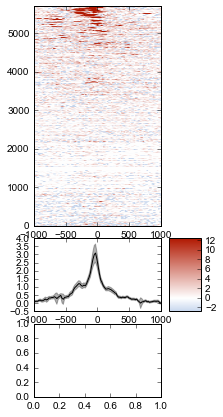

In [32]:
fig = metaseq.plotutils.imshow(
    # Same as before...
    normalized_subtracted,
    x=x,
    figsize=(3, 7),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=normalized_subtracted.mean(axis=1),
    
    
    # Default was (3,1); here we add another number 
    height_ratios=(3, 1, 1)
)

# `fig.gs` contains the `matplotlib.gridspec.GridSpec` object,
# so we can now create the new axes.
bottom_axes = plt.subplot(fig.gs[2, 0])


The `metaseq.plotutils.ci_plot` function takes an array and plots the mean signal +/- 95% CI bands. This was actually called automatically before for our line plot of average signal across all TSSes. 

Now, let's create a custom plot that separates TSSes into up, down, and unchanged in the ATF3 knockdown.

Importantly, since we've aligned the RNA-seq data table and the array, we can calculate subsets in the RNA-seq data  (as boolean indexes) and use those same indexes into the array itself.

For clarity, let's split up each step separately for the upregulated genes.

In [33]:
# This is a pandas.Series, True where the log2foldchange was >1
upregulated = (data.log2foldchange > 1)
upregulated

id
ENST00000318008    False
ENST00000419929    False
ENST00000433206     True
ENST00000435347    False
ENST00000443937    False
ENST00000359238    False
ENST00000393405     True
ENST00000439357    False
ENST00000452859     True
ENST00000003834     True
ENST00000379061    False
ENST00000457710    False
ENST00000003607    False
ENST00000540200     True
ENST00000158166     True
ENST00000348335     True
ENST00000381769    False
ENST00000381771     True
ENST00000066544    False
ENST00000446365    False
ENST00000525495    False
ENST00000526866     True
ENST00000527547    False
ENST00000528147    False
ENST00000528748    False
ENST00000531206     True
ENST00000532575    False
ENST00000532893    False
ENST00000533415    False
ENST00000262418    False
                   ...  
ENST00000564292    False
ENST00000569655    False
ENST00000562897    False
ENST00000562672    False
ENST00000566986    False
ENST00000568641    False
ENST00000566532    False
ENST00000563583    False
ENST00000563763    Fal

In [34]:
# This gets us the underlying boolean NumPy array which we
# can use to subset the array
index = upregulated.values
index

array([False, False,  True, ..., False, False, False], dtype=bool)

In [35]:
# This is the subset of the array where the TSS of the transcript
# went up in the ATF3 knockdown
upregulated_chipseq_signal = normalized_subtracted[index, :]
upregulated_chipseq_signal

array([[ 1.03915645, -1.84141782,  0.03746102, ..., -1.84141782,
         3.11746936,  3.11746936],
       [-1.84141782,  2.07831291,  0.        , ...,  1.03915645,
         1.03915645, -2.88057427],
       [-2.88057427,  2.07831291,  2.07831291, ...,  0.        ,
         1.03915645, -1.84141782],
       ..., 
       [ 1.03915645, -1.84141782,  1.27605155, ...,  0.        ,
         0.        , -2.88057427],
       [ 0.        , -2.88057427,  0.        , ..., -0.80226136,
         1.86838231,  4.15662582],
       [ 0.        ,  0.        ,  0.        , ..., -1.84141782,
        -1.84141782, -8.64172281]])

In [36]:
# We can combine the above steps into the following:
subset = normalized_subtracted[(data.log2foldchange > 1).values, :]

Now we just use the same technique for the up, down, and unchanged transcripts. Each one of them gets passed to the `ci_plot` method, which plots the line in the color we specify (`line_kwargs`, `fill_kwargs`) on the axes we specify (`bottom_axes`).

In [37]:
# Signal over TSSs of transcripts that were activated upon knockdown.
metaseq.plotutils.ci_plot(
    x,
    normalized_subtracted[(data.log2foldchange > 1).values, :],
    line_kwargs=dict(color='#fe9829', label='up'),
    fill_kwargs=dict(color='#fe9829', alpha=0.3),
    ax=bottom_axes)

# Signal over TSSs of transcripts that were repressed upon knockdown
metaseq.plotutils.ci_plot(
    x,
    normalized_subtracted[(data.log2foldchange < -1).values, :],
    line_kwargs=dict(color='#8e3104', label='down'),
    fill_kwargs=dict(color='#8e3104', alpha=0.3),
    ax=bottom_axes)

# Signal over TSSs tof transcripts that did not change upon knockdown
metaseq.plotutils.ci_plot(
    x,
    normalized_subtracted[((data.log2foldchange >= -1) & (data.log2foldchange <= 1)).values, :],
    line_kwargs=dict(color='.5', label='unchanged'),
    fill_kwargs=dict(color='.5', alpha=0.3),
    ax=bottom_axes);

Finally, we do some cleaning up to make the figure look nicer (axes labels, legend, vertical lines at zero):

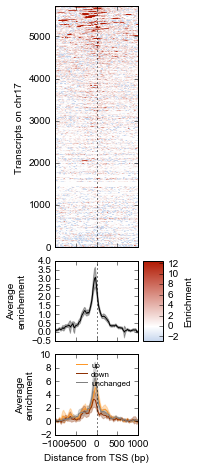

In [38]:
# Clean up redundant x tick labels, and add axes labels
fig.line_axes.set_xticklabels([])
fig.array_axes.set_xticklabels([])
fig.line_axes.set_ylabel('Average\nenrichement')
fig.array_axes.set_ylabel('Transcripts on chr17')
bottom_axes.set_ylabel('Average\nenrichment')
bottom_axes.set_xlabel('Distance from TSS (bp)')
fig.cax.set_ylabel('Enrichment')

# Add the vertical lines for TSS position to all axes
for ax in [fig.line_axes, fig.array_axes, bottom_axes]:
    ax.axvline(0, linestyle=':', color='k')

# Nice legend
bottom_axes.legend(loc='best', frameon=False, fontsize=8, labelspacing=.3, handletextpad=0.2)
fig.subplots_adjust(left=0.3, right=0.8, bottom=0.05)
fig

We can save the figure to disk in different formats for manuscript preparation:

In [39]:
fig.savefig('demo.png')
fig.savefig('demo.svg')

It appears that transcripts unchanged by ATF3 knockdown have the strongest ChIP signal.  Transcripts that went up upon knockdown (that is, ATF3 normally represses them) had a slightly higher signal than those transcripts that went down (normally activated by ATF3). 

Interestingly, even though we used a crude cutoff of 2-fold for a single replicate, and we only looked at chr17, the direction of the relationship we see here -- where ATF3-repressed genes have a higher signal than ATF3-activated -- is consistent with ATF3's known repressive role.

# Extras
This section shows some examples of more advanced `metaseq` usage without as much explanatory text as above. More knowledge about `pandas`, `numpy`, and `matplotlib` are expected here.  For further details, see the `metaseq` docs and source code for the functions used below.

## K-means clustering of ChIP-seq signal
Note that K-means clustering is non-deterministic -- running it multiple times will give different clusters since the initial state is set randomly.

In [40]:
# K-means input data should be normalized (mean=0, stddev=1)
from sklearn import preprocessing
X_scaled = preprocessing.scale(normalized_subtracted)

k = 4

ind, breaks = metaseq.plotutils.new_clustered_sortind(
    
    # The array to cluster
    X_scaled,
    
    # Within each cluster, how the rows should be sorted
    row_key=np.mean,
    
    # How each cluster should be sorted
    cluster_key=np.median,
    
    # Number of clusters
    k=k)

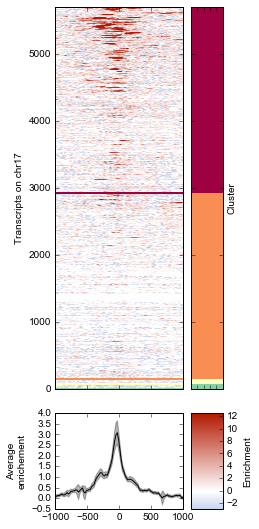

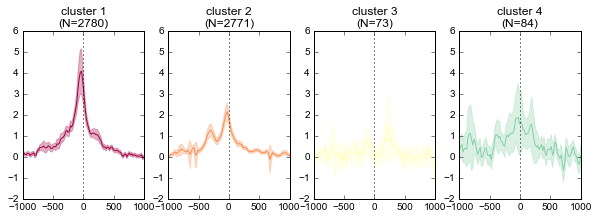

In [41]:
# Plot the heatmap again
fig = metaseq.plotutils.imshow(
    normalized_subtracted,
    x=x,
    figsize=(3, 9),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3), 
    
    # A little tricky: `sort_by` expects values to sort by
    # (say, expression values). But we've pre-calculated 
    # our actual sort index based on clusters, so we transform
    # it like this
    sort_by=np.argsort(ind),
    
    # This adds a "strip" axes on the right side, useful
    # for adding extra information. We'll add cluster color
    # codes here.
    strip=True,
)

# De-clutter by hiding labels
plt.setp(
    fig.strip_axes.get_yticklabels() 
    + fig.strip_axes.get_xticklabels()
    + fig.array_axes.get_xticklabels(),
    visible=False)

# 
fig.line_axes.set_ylabel('Average\nenrichement')
fig.array_axes.set_ylabel('Transcripts on chr17')
fig.strip_axes.yaxis.set_label_position('right')
fig.strip_axes.set_ylabel('Cluster')
fig.cax.set_ylabel('Enrichment')

# Make colors
import matplotlib
cmap = matplotlib.cm.Spectral
colors = cmap(np.arange(k) / float(k))

# This figure will contain average signal for each cluster
fig2 = plt.figure(figsize=(10,3))


last_break = 0
cluster_number = 1
n_panel_rows = 1
n_panel_cols = k
for color, this_break in zip(colors, breaks):
    if cluster_number == 1:
        sharex = None
        sharey = None
    else:
        sharex = fig2.axes[0]
        sharey = fig2.axes[0]
        
    ax = fig2.add_subplot(
        n_panel_rows,
        n_panel_cols,
        cluster_number,
        sharex=sharex,
        sharey=sharey)
    
    # The y position is somewhat tricky: the array was 
    # displayed using matplotlib.imshow with the argument 
    # `origin="lower"`, which means the row in the plot at y=0
    # corresponds to the last row in the array (index=-1).
    # But the  breaks are in array coordinates. So we convert
    # them by subtracting from the total array size.
    xpos = 0
    width = 1
    ypos = len(normalized_subtracted) - this_break
    height = this_break - last_break   
    rect = matplotlib.patches.Rectangle(
        (xpos, ypos), width=width, height=height, color=color)
    fig.strip_axes.add_patch(rect)
    fig.array_axes.axhline(ypos, color=color, linewidth=2)

    chunk = normalized_subtracted[last_break:this_break]
    
    metaseq.plotutils.ci_plot(
        x,
        chunk,
        ax=ax,
        line_kwargs=dict(color=color),
        fill_kwargs=dict(color=color, alpha=0.3),
        )
    ax.axvline(0, color='k', linestyle=':')
    ax.set_title('cluster %s\n(N=%s)' % (cluster_number, len(chunk)))
    cluster_number += 1
    last_break = this_break
      

## Scatterplots of RNA-seq and ChIP-seq signal
More examples of integrating ChIP-seq and RNA-seq.  This uses the `data` dataframe created above, which contains RNA-seq data aligned with the ChIP-seq array.

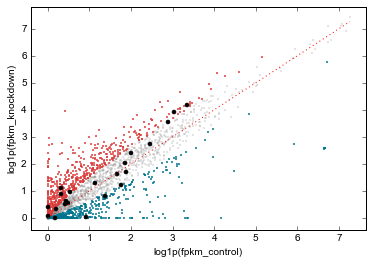

In [42]:
# Convert to ResultsTable so we can take advantage of its
# `scatter` method
rt = ResultsTable(data)

# Get the up/down regulated
up = rt.log2foldchange > 1
dn = rt.log2foldchange < -1

# Go back to the ChIP-seq data and create a boolean array
# that is True only for the top TSSes with the strongest
# mean signal
tss_means = normalized_subtracted.mean(axis=1)
strongest_signal = np.zeros(len(tss_means)) == 1
strongest_signal[np.argsort(tss_means)[-25:]] = True

rt.scatter(
    x='fpkm_control',
    y='fpkm_knockdown',
    xfunc=np.log1p,
    yfunc=np.log1p,
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8)),
        (strongest_signal, dict(color='k', s=50, alpha=1)),
                            
    ],
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    one_to_one=dict(color='r', linestyle=':')
);

/home/ryan/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:1290: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  positions.sort()
/home/ryan/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:1295: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  positions.sort()


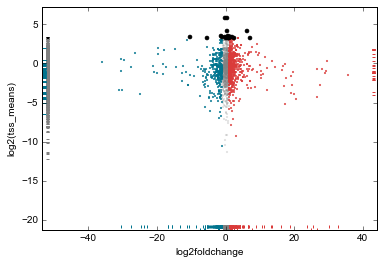

In [43]:
# Perhaps a better analysis would be to plot average
# ChIP-seq signal vs log2foldchange directly. In an imaginary 
# world where biology is simple, we might expect TSSes with stronger
# log2foldchange upon knockdown to have stronger ChIP-seq signal
# in the control.
#
# To take advantage of the `scatter` method of ResultsTable objects,
# we simply add the TSS signal means as another variable in the
# dataframe. Then we can refer to it by name in `scatter`.
#
# We'll also use the same colors and genes to highlight from
# above.

rt.data['tss_means'] = tss_means
rt.scatter(
    x='log2foldchange',
    y='tss_means',
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8)),
        (strongest_signal, dict(color='k', s=50, alpha=1)),                       
    ],
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    yfunc=np.log2);